In [2]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler  # Add this import


2023-10-18 01:56:23.617612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib:/home/sandeepmishra/catkin_ws/src/Firmware/build/posix_sitl_default/build_gazebo
2023-10-18 01:56:23.617668: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-18 01:56:25.275027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib:/home/sandeepmishra/catkin_ws/src/Firmware/build/posix_sitl_default/build_gazebo
2023-10-18 01:56:25.275244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
#using Tensorflow

In [4]:
# LOAD THE DATA
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [5]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)
Y_train = to_categorical(Y_train, num_classes=10)


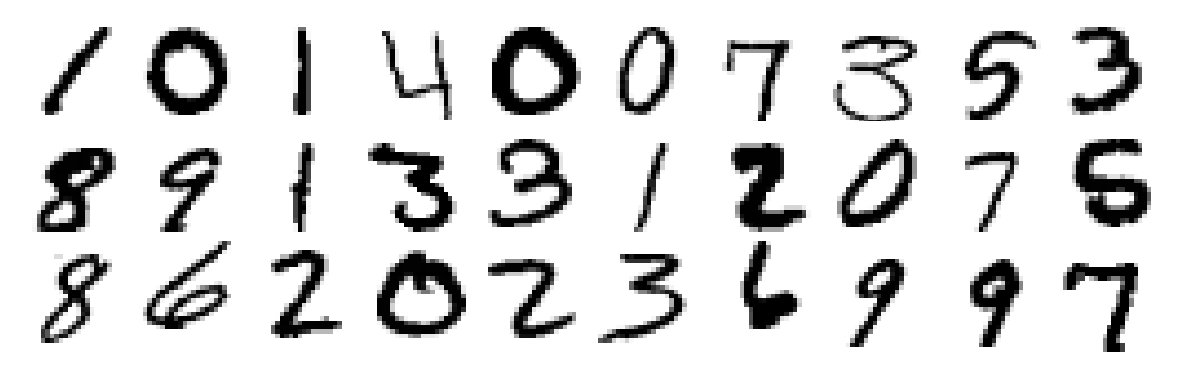

In [6]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [7]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)


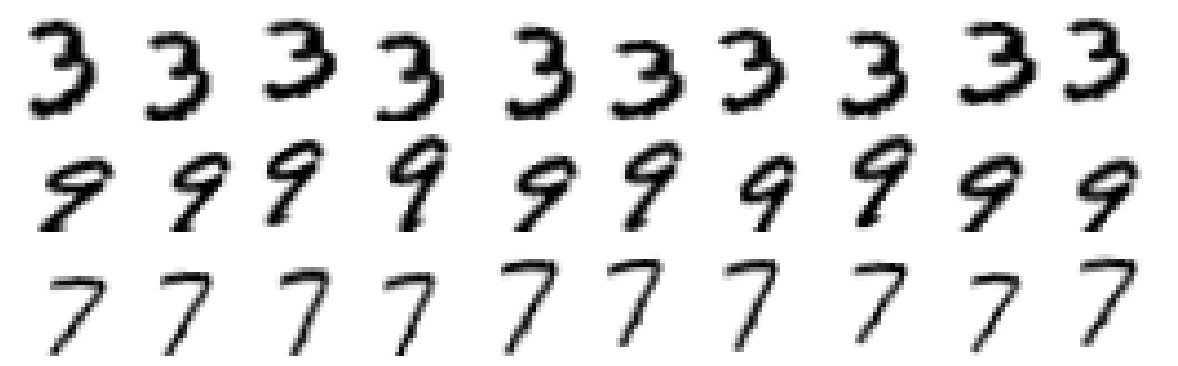

In [8]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature maps for the fully connected layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

2023-10-18 01:56:58.255439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib:/home/sandeepmishra/catkin_ws/src/Firmware/build/posix_sitl_default/build_gazebo
2023-10-18 01:56:58.255474: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-18 01:56:58.255500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sandeepmishra-ThinkPad-T430): /proc/driver/nvidia/version does not exist


In [10]:
import tensorflow as tf

# Create a TensorFlow Dataset for efficient data loading
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(128)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Define a simpler data augmentation strategy
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Modify the learning rate scheduler
annealer = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.99)


In [11]:
epochs = 15
batch_size = 128

X_val2, Y_val2 = X_train2[:5000], Y_train2[:5000]  # Use a smaller validation set

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=(X_val2, Y_val2),
    callbacks=[early_stopping, annealer],
)

Epoch 1/15
329/329 [==============================] - 31s 92ms/step - loss: 0.3889 - accuracy: 0.8840 - val_loss: 2.5110 - val_accuracy: 0.0000e+00 - lr: 9.9000e-04
Epoch 2/15
329/329 [==============================] - 31s 93ms/step - loss: 0.1031 - accuracy: 0.9680 - val_loss: 5.3724 - val_accuracy: 0.0000e+00 - lr: 9.8010e-04
Epoch 3/15
329/329 [==============================] - 31s 95ms/step - loss: 0.0755 - accuracy: 0.9769 - val_loss: 3.0823 - val_accuracy: 0.0000e+00 - lr: 9.7030e-04
Epoch 4/15
329/329 [==============================] - 31s 93ms/step - loss: 0.0560 - accuracy: 0.9830 - val_loss: 4.6109 - val_accuracy: 0.0000e+00 - lr: 9.6060e-04
Epoch 5/15
329/329 [==============================] - 31s 93ms/step - loss: 0.0455 - accuracy: 0.9857 - val_loss: 3.2185 - val_accuracy: 0.0000e+00 - lr: 9.5099e-04
Epoch 6/15
329/329 [==============================] - 31s 95ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 6.5473 - val_accuracy: 0.0000e+00 - lr: 9.4148e-04


In [12]:
print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    epochs,
    int(max(history.history['accuracy'])),  # Format accuracy as an integer
    max(history.history['accuracy']),  # Use index 1 for training accuracy
    max(history.history['val_accuracy']),  # Use index 2 for validation accuracy
))



CNN 15: Epochs=0, Train accuracy=0.98767, Validation accuracy=0.00000


In [14]:
import numpy as np
import pandas as pd

# Assuming X_test is a Pandas DataFrame
# Convert it to a NumPy array
X_test_array = X_test.values

# Reshape the NumPy array
X_test_array = X_test_array.reshape(-1, 28, 28, 1)

# Perform predictions
results = model.predict(X_test_array)
results = np.argmax(results, axis=1)

# Convert the NumPy array to a Pandas Series
results_series = pd.Series(results, name="Label")

# Create a submission dataframe
submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results_series], axis=1)

# Save the submission to a CSV file
submission.to_csv("MNIST-CNN-NUMBER-RECOGNITION-ENSEMBLE.csv", index=False)




875/875 [==============================] - 7s 8ms/step


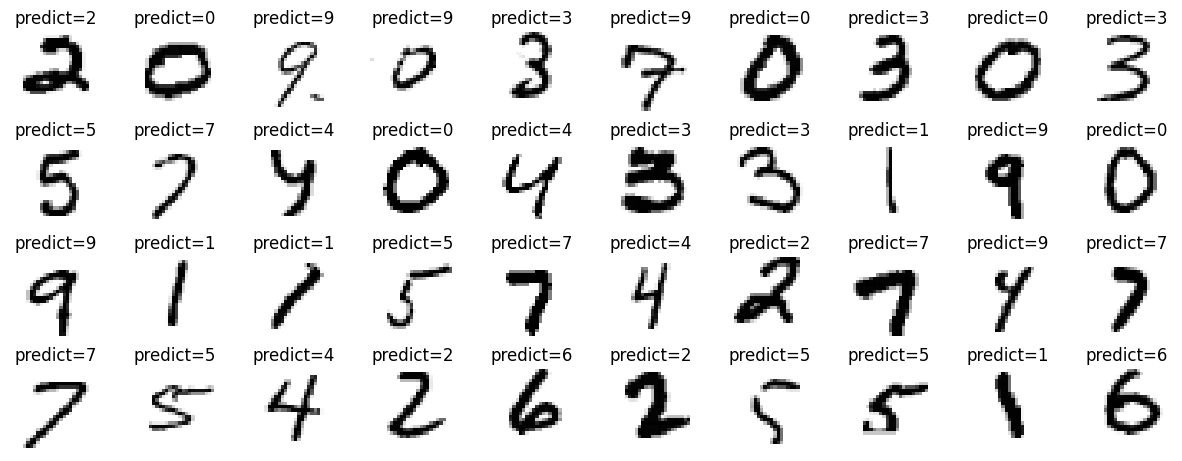

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(X_test_array[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i], y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()



In [1]:
#Accuracy 98.767 %